# Analyzing integration timescales with spectral coherence

In [1]:
%matplotlib inline
import cortex
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import h5py
import os
import nibabel as nib
from collections import defaultdict 
import statsmodels.api as sm

#### Load language data

In [2]:
path = '/Users/jiamingxu/Desktop/Language_straightenting/data/language/AA_wheretheressmoke.hf5'
with h5py.File(path, 'r') as file:
    file_name = list(file.keys())[0]
    response_trials = np.array(file[file_name])
    # get rid of the first 50 TRs (due to onset effect in AC)
    response_trials = response_trials[:, 50:, :]
    print(response_trials.shape) 

subject, xfm = 'AA', '20180905AA-sg-auto'
mask = cortex.db.get_mask(subject, xfm)

(10, 241, 95556)


## 1. Estimate PSD for each frequency bin

Re-normalize after averaging across repeats for each voxel

In [3]:
# zero all the remaining nans
response_trials = np.nan_to_num(response_trials,nan=0)

In [4]:
avg_reps = np.mean(response_trials,0)
means = np.mean(avg_reps,0)
stds = np.std(avg_reps,0)
stds_nonzero = np.where(stds != 0, stds, 1)  # Replace 0s in stds with 1 to avoid division by zero
norm_avg_reps = (avg_reps - means) / stds_nonzero
norm_vars = np.var(norm_avg_reps,0)
print("norm var: ",norm_vars)

norm var:  [1. 1. 1. ... 1. 1. 1.]


Get PSD

In [5]:
freqs, Pxx = sp.signal.welch(norm_avg_reps, fs=0.5, axis=0, nperseg=64)          

Notes: averaged across repeats; fs = sampling freq, each data point represents a 2-s interval; axis = 0 the Welch method should
be applied to the first axis of the input array; nperseg = 64 sets the length of each segment in the Welch method
returns 2 arrays: freqs - frequency bins; Pxx - estimates PSD for each frequency bin

#### 1) Plot average PSD of each frequency bin (whole brain)

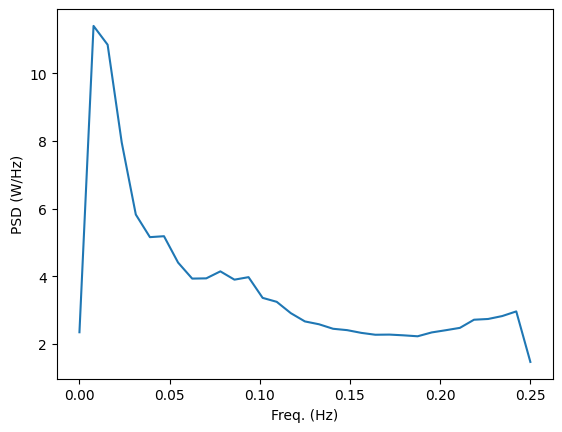

In [5]:
mu_pxx = np.mean(Pxx,axis = 1) # averaged across all voxels
mu_pxx.shape
plt.plot(freqs, mu_pxx.T)

plt.xlabel('Freq. (Hz)')
plt.ylabel('PSD (W/Hz)')
plt.savefig("wholebrain_psd_language.pdf", format='pdf', bbox_inches='tight')

#### 2) Plot average PSD of each frequency bin (selected ROIs)

In [6]:
# choose functional roi 
# f_rois = ['V1','V2','V3','FFA']  
f_rois = ['AC','sPMv']
f_roi_voxs = {} # get indices of roi voxels in cortical map
# get 3d mask of voxels that belong to roi
roi_masks = cortex.utils.get_roi_masks(subject, xfm, roi_list=f_rois, gm_sampler='cortical', split_lr=False, threshold=None, return_dict=True)
for roi in f_rois:
    roi_mask = roi_masks[roi]
    f_roi_voxs[roi] = np.where(roi_mask[np.where(mask)])[0]

Cutting 0 overlapping voxels (should be < ~50)


In [7]:
len(f_roi_voxs)
for key, value in f_roi_voxs.items():
    print(f"{key}: {len(value)} items")

AC: 2124 items
sPMv: 271 items


In [7]:
# choose anatomical roi (PFC & precuneus)
%cd 'data/rois'
a_roi = ['parsopercularis','parstriangularis','superiorfrontal','rostralmiddlefrontal','caudalmiddlefrontal','frontalpole','precuneus']
roi_data = np.load(f'{subject}_roi.npy', allow_pickle=True).item()
a_roi_voxs = {}
for roi in a_roi:
    a_roi_voxs[roi] = roi_data[roi]
    
# combine PFC rois
rois_to_combine = [
    'parsopercularis',
    'parstriangularis',
    'superiorfrontal',
    'rostralmiddlefrontal',
    'caudalmiddlefrontal',
    'frontalpole'
]
pfc_voxs = []
for roi in rois_to_combine:
    pfc_voxs.extend(a_roi_voxs[roi])
    
pfc_voxs = list(set(pfc_voxs)) # remove potential duplicates

a_roi_voxs['prefrontal'] = pfc_voxs # update dict 

for roi in rois_to_combine: # remove old keys
    del a_roi_voxs[roi]


# combine functional and anatomical
roi_voxs = {**f_roi_voxs, **a_roi_voxs}  

# print number of voxels in each ROI
len(roi_voxs)
for key, value in roi_voxs.items():
    print(f"{key}: {len(value)} items")

/Users/jiamingxu/Desktop/Language_straightenting/data/rois
AC: 2124 items
sPMv: 271 items
precuneus: 2845 items
prefrontal: 15222 items


/Users/jiamingxu/miniconda3/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


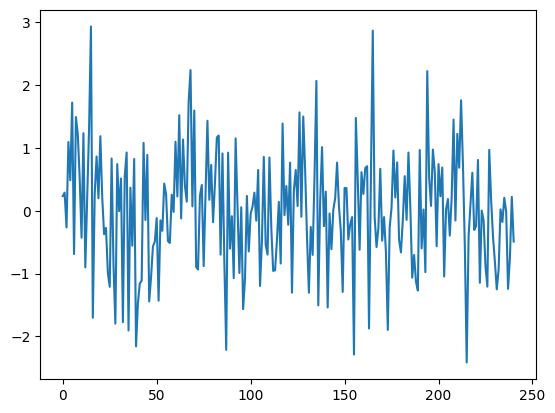

In [38]:
# plot raw data from one example voxel in selected roi
import random
roi = "prefrontal"
selected_vox = random.choice(roi_voxs[roi])
plt.plot(np.arange(len(response_trials[1])),response_trials[0,:,selected_vox])
plt.savefig("pfc.pdf", format='pdf', bbox_inches='tight')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


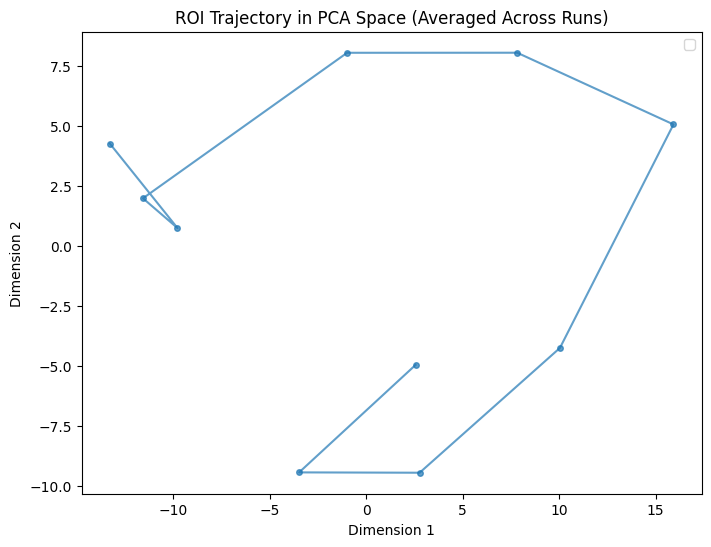

In [49]:
from sklearn.decomposition import PCA

# Assume the following variables are defined:
# response_trials: fMRI data of shape (10, 241, 95556)
# roi_voxel_indices: List of voxel indices for the specific ROI

# Example setup
roi = "AC"
roi_voxel_indices = roi_voxs[roi]

# Step 1: Extract data for the ROI
roi_data = response_trials[:, 0:10, roi_voxel_indices]  # Shape: (10, 241, number of voxels in ROI)

# Step 2: Take the average across the 10 runs
roi_data_avg = roi_data.mean(axis=0)  # Shape: (241, number of voxels in ROI)

# Step 3: Perform PCA to reduce dimensions to 2
pca = PCA(n_components=2)
roi_pca = pca.fit_transform(roi_data_avg)  # Shape: (241, 2)

# Step 4: Plot the trajectory in the 2D PCA space
plt.figure(figsize=(8, 6))
plt.plot(roi_pca[:, 0], roi_pca[:, 1], '-o', markersize=4, alpha=0.7)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('ROI Trajectory in PCA Space (Averaged Across Runs)')
plt.legend()
plt.savefig("vox_trajectory_pca.pdf", format='pdf', bbox_inches='tight')
plt.show()

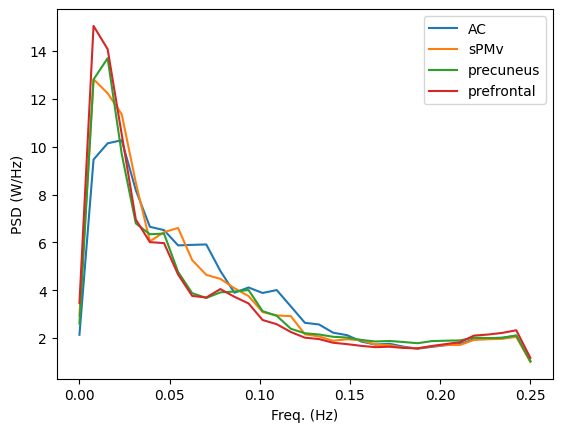

In [9]:
# plot PSD over frequency bins
for roi in roi_voxs:
    mu_roi_pxx = np.mean(Pxx[:,roi_voxs[roi]], axis=1)
    plt.plot(freqs, mu_roi_pxx.T,label=roi)
plt.xlabel('Freq. (Hz)')
plt.ylabel('PSD (W/Hz)')
plt.legend()
plt.savefig("psd_language.pdf", format='pdf', bbox_inches='tight')

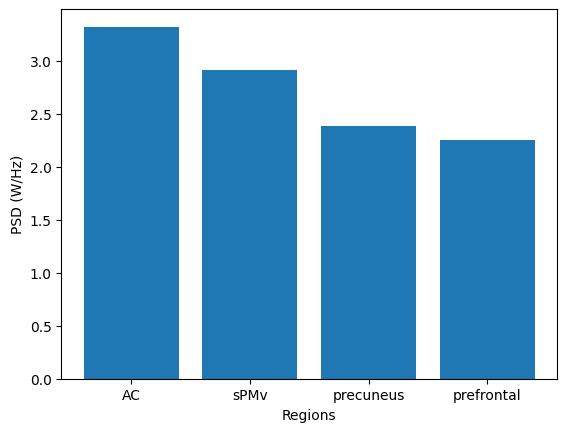

In [33]:
# better visualization
freq_index = np.argmin(np.abs(freqs - 0.12))

psd_values = []

# Extract the PSD values for each ROI at the identified frequency index
for roi in roi_voxs:
    mu_roi_pxx = np.mean(Pxx[:, roi_voxs[roi]], axis=1)  # Get mean PSD for each ROI
    psd_value_at_0_01 = mu_roi_pxx[freq_index]  # Get PSD value at 0.01 Hz
    psd_values.append(psd_value_at_0_01)  # Store it for histogram plotting

# Plot a histogram of the PSD values
plt.figure()
plt.bar(roi_voxs.keys(), psd_values)
plt.xlabel('Regions')
plt.savefig("psd_0.12.pdf", format='pdf', bbox_inches='tight')
plt.ylabel('PSD (W/Hz)')
plt.show()

#### 3) Plot center of mass for each frequency spectrum (weighted by PSD) 

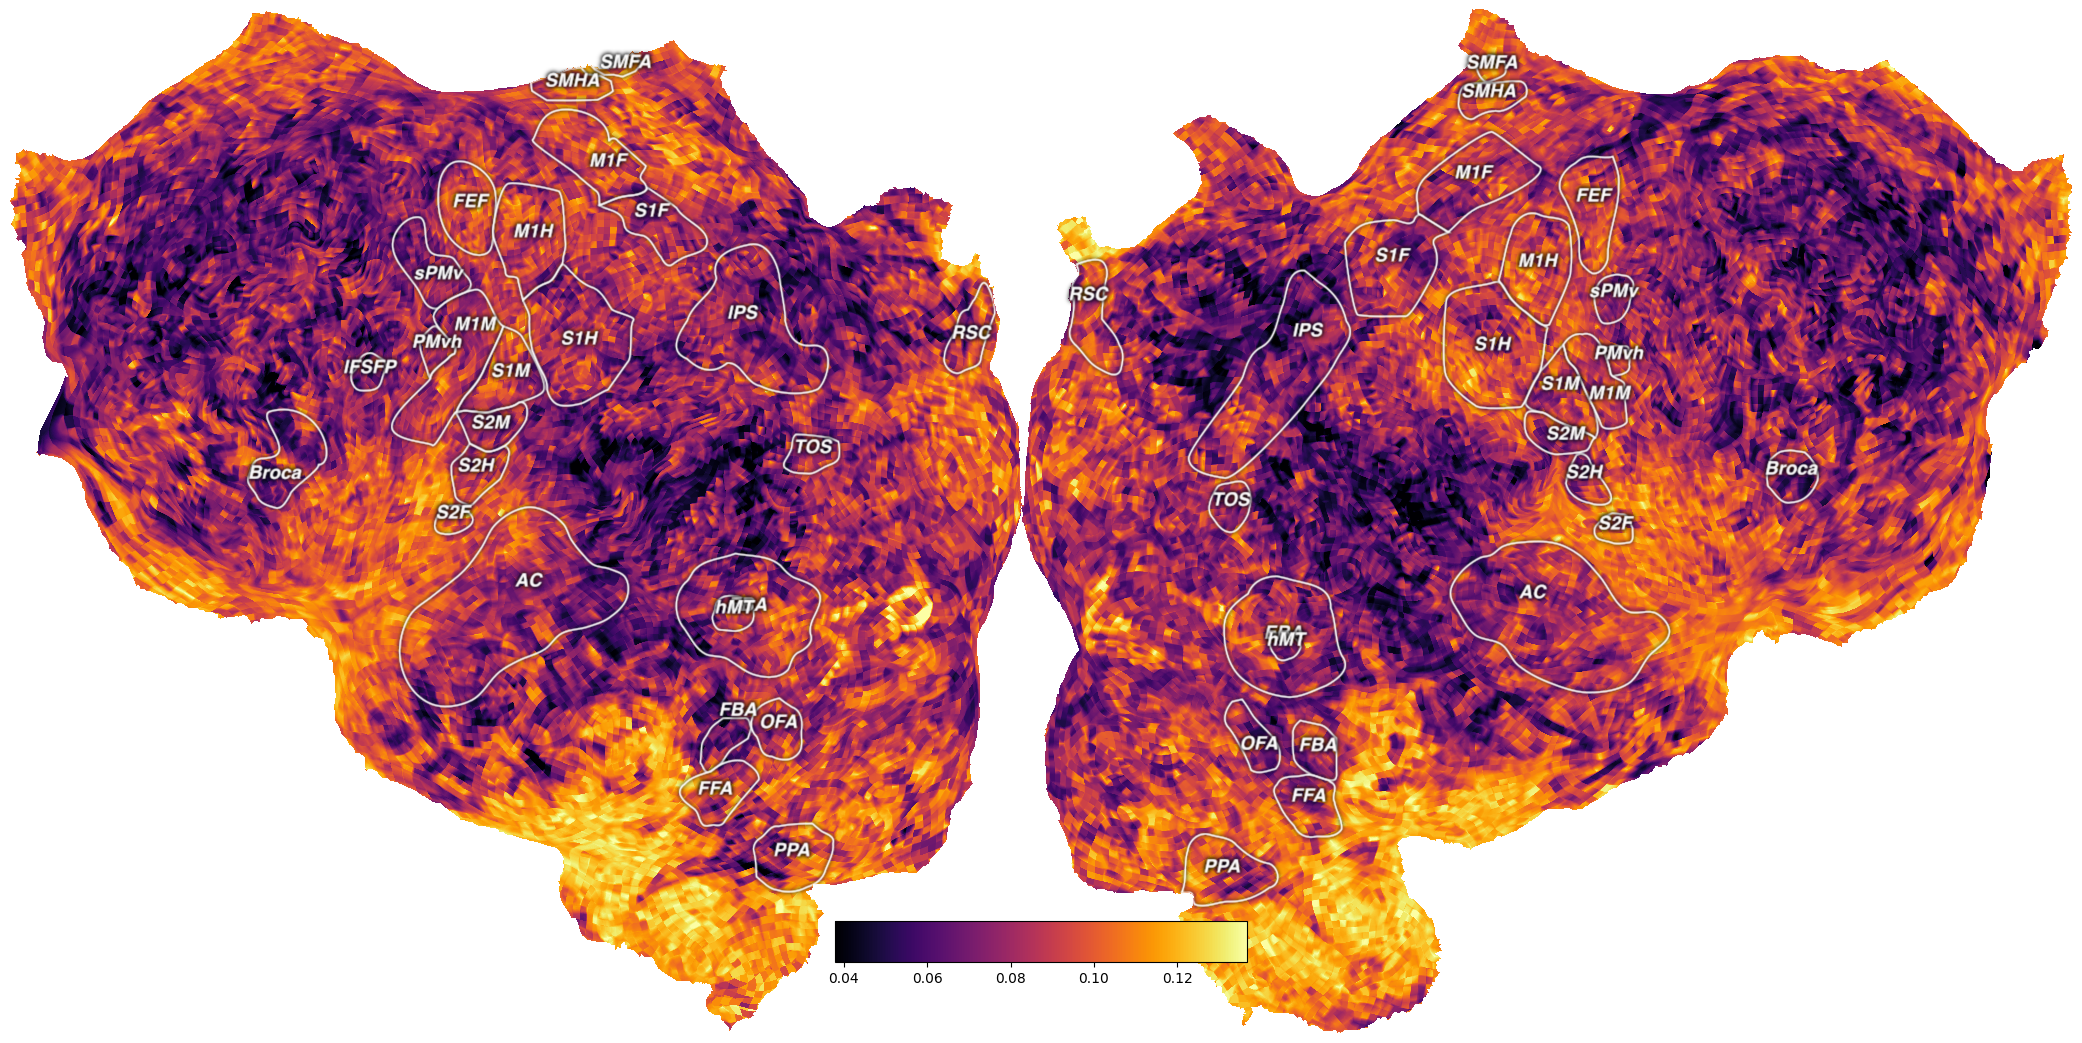

In [9]:
# Plot with pycortex
vol_data = np.average(np.broadcast_to(freqs[:, None], Pxx.shape), weights=Pxx, axis=0) # weighted average of frequency bins by power
vol = cortex.Volume(vol_data, subject, xfmname=xfm, cmap='inferno')
cortex.quickshow(vol);
plt.savefig("psd_language_brainmap.pdf", format='pdf', bbox_inches='tight')

In [10]:
cortex.webshow(vol, port=1420);

Started server on port 1420


## 2. Compute coherence as a measure of SNR

In [10]:
from scipy.signal import welch

def compute_coherence_spectrum(data, fs, nfft=64):
    """
    Computes the coherence spectrum for voxel responses across repeats.
    [data] is a 2D matrix: repeats x time x voxels.
    [fs] is the sampling rate of the data (e.g., 0.5 for a 2-second TR).
    [nfft] is the FFT window size for power spectral density estimation.

    Based on Hsu, Borst, Theunissen (2004).
    """
    noverlap = nfft // 2
    params = dict(nperseg=nfft, fs=fs, noverlap=noverlap)

    signal = np.mean(data, axis=0)  # Shape: (time,voxels)

    noise = data - signal  # Shape: (repeats, time, voxel)
    noise = noise.reshape(-1, data.shape[-1])

    freqs, spower = welch(signal, axis=0, **params)
    _, npower = welch(noise, axis=0, **params)

    # Jackknife noise: Vectorized computation of mean excluding each trial
    sum_all_trials = np.sum(data, axis=0, keepdims=True)  # Sum of all trials
    mean_remaining_trials = (sum_all_trials - data) / (data.shape[0] - 1)  # Exclude each trial's contribution
    
    # Compute jackknife noise as deviations from the mean of remaining trials
    jnoises = data - mean_remaining_trials  # Shape: (repeats, time, voxel)

    jnoises_flat = jnoises.reshape(-1, data.shape[-1])
    _, jnpower = welch(jnoises_flat, axis=0, **params)

    coherence_upper = spower / (npower + spower)
    coherence_lower = spower / (jnpower + spower)

    return freqs, spower, npower, jnpower, coherence_upper, coherence_lower


#### 1) Compute upper/lower bounds of coherence for all voxels

In [11]:
%%time
freqs, spower, npower, jnpower, coherence_upper, coherence_lower = compute_coherence_spectrum(response_trials, fs=0.5, nfft=64)

CPU times: user 8.22 s, sys: 16 s, total: 24.2 s
Wall time: 39.1 s


#### 2) Plot coherence spectrum (averaged across all voxels within each ROI)

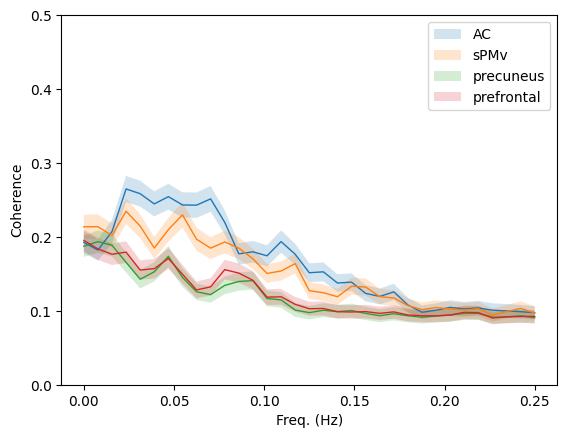

In [106]:
for roi in roi_voxs:
    ub_coherence = np.mean(coherence_upper[:,roi_voxs[roi]], axis=1)
    lb_coherence = np.mean(coherence_lower[:,roi_voxs[roi]], axis=1)
    plt.fill_between(freqs, lb_coherence, ub_coherence, alpha=0.2, label=roi)
    
    mean_coherence = (ub_coherence + lb_coherence) / 2
    plt.plot(freqs, mean_coherence, linewidth=1)

plt.xlabel('Freq. (Hz)')
plt.ylabel('Coherence')
plt.ylim(0, 0.5)  
plt.legend()

#### 3) Find baseline coherence and subtract it out

Break the signals down into 10TR segments, shuffle them around and compute coherence.

In [12]:
# breaking down and shuffling
nRep = response_trials.shape[0]
segment_size = 10  
n_segments = response_trials.shape[1] // segment_size  
shuffled_resps = np.zeros_like(response_trials)

for i in range(nRep):
    segments = np.array_split(response_trials[i, :n_segments * segment_size, :], indices_or_sections=n_segments, axis=0)
    last_segment = response_trials[i, n_segments * segment_size:, :]  
    np.random.shuffle(segments)
    if last_segment.size > 0:  # Only concatenate if the last segment is non-empty
        shuffled_vec = np.concatenate(segments + [last_segment], axis=0)
    else:
        shuffled_vec = np.concatenate(segments, axis=0)
    shuffled_resps[i,:,:] = shuffled_vec

In [13]:
# compute coherence again
freqs, spower_seg, npower_seg, jnpower_seg, coherence_upper_seg, coherence_lower_seg = compute_coherence_spectrum(shuffled_resps, fs=0.5, nfft=64)

In [14]:
# get mean baseline
baselines = np.zeros((len(roi_voxs), len(freqs)))
idx = 0
for roi in roi_voxs:
    ub_coherence_seg = np.mean(coherence_upper_seg[:,roi_voxs[roi]], axis=1)
    lb_coherence_seg = np.mean(coherence_lower_seg[:,roi_voxs[roi]], axis=1)    
    mean_coherence = (ub_coherence_seg + lb_coherence_seg) / 2
    baselines[idx, :] = mean_coherence
    idx += 1

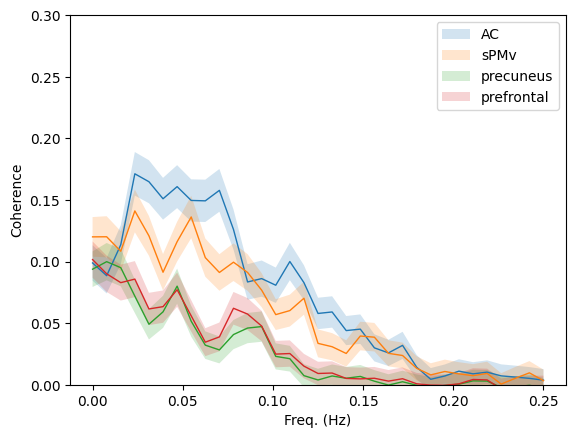

In [24]:
# subtract baseline from real coherence values
mean_baseline = np.mean(baselines)
coherence_upper_denoise = coherence_upper - mean_baseline
coherence_lower_denoise = coherence_lower - mean_baseline
for roi in roi_voxs:
    ub_coherence_denoise = np.mean(coherence_upper_denoise[:,roi_voxs[roi]], axis=1)
    lb_coherence_denoise = np.mean(coherence_lower_denoise[:,roi_voxs[roi]], axis=1)
    plt.fill_between(freqs, lb_coherence_denoise, ub_coherence_denoise, alpha=0.2, label=roi)
    
    mean_coherence_denoise = (ub_coherence_denoise + lb_coherence_denoise) / 2
    plt.plot(freqs, mean_coherence_denoise, linewidth=1)

plt.xlabel('Freq. (Hz)')
plt.ylabel('Coherence')
plt.ylim(0, 0.3)  
plt.legend()
plt.savefig("coherence_dist.pdf", format='pdf', bbox_inches='tight')


#### 4) normalize, show relative coherence spectrum

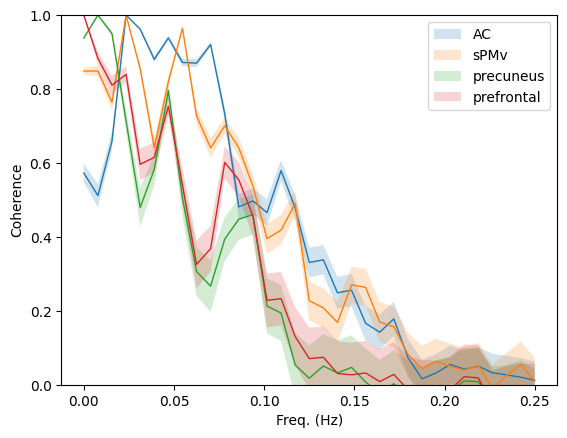

In [80]:
def normalize_by_max(coherence_values):
    return coherence_values / np.max(coherence_values)

for roi in roi_voxs:
    ub_coherence_denoise = np.mean(coherence_upper_denoise[:,roi_voxs[roi]], axis=1)
    lb_coherence_denoise = np.mean(coherence_lower_denoise[:,roi_voxs[roi]], axis=1)

    ub_coherence_norm = normalize_by_max(ub_coherence_denoise)
    lb_coherence_norm = normalize_by_max(lb_coherence_denoise)
    
    plt.fill_between(freqs, lb_coherence_norm, ub_coherence_norm, alpha=0.2, label=roi)
    
    mean_coherence_norm = (ub_coherence_norm + lb_coherence_norm) / 2
    plt.plot(freqs, mean_coherence_norm, linewidth=1)

plt.xlabel('Freq. (Hz)')
plt.ylabel('Coherence')
plt.ylim(0, 1)  
plt.legend()
    

#### 5) Plot center of mass frequency weighted by coherence 

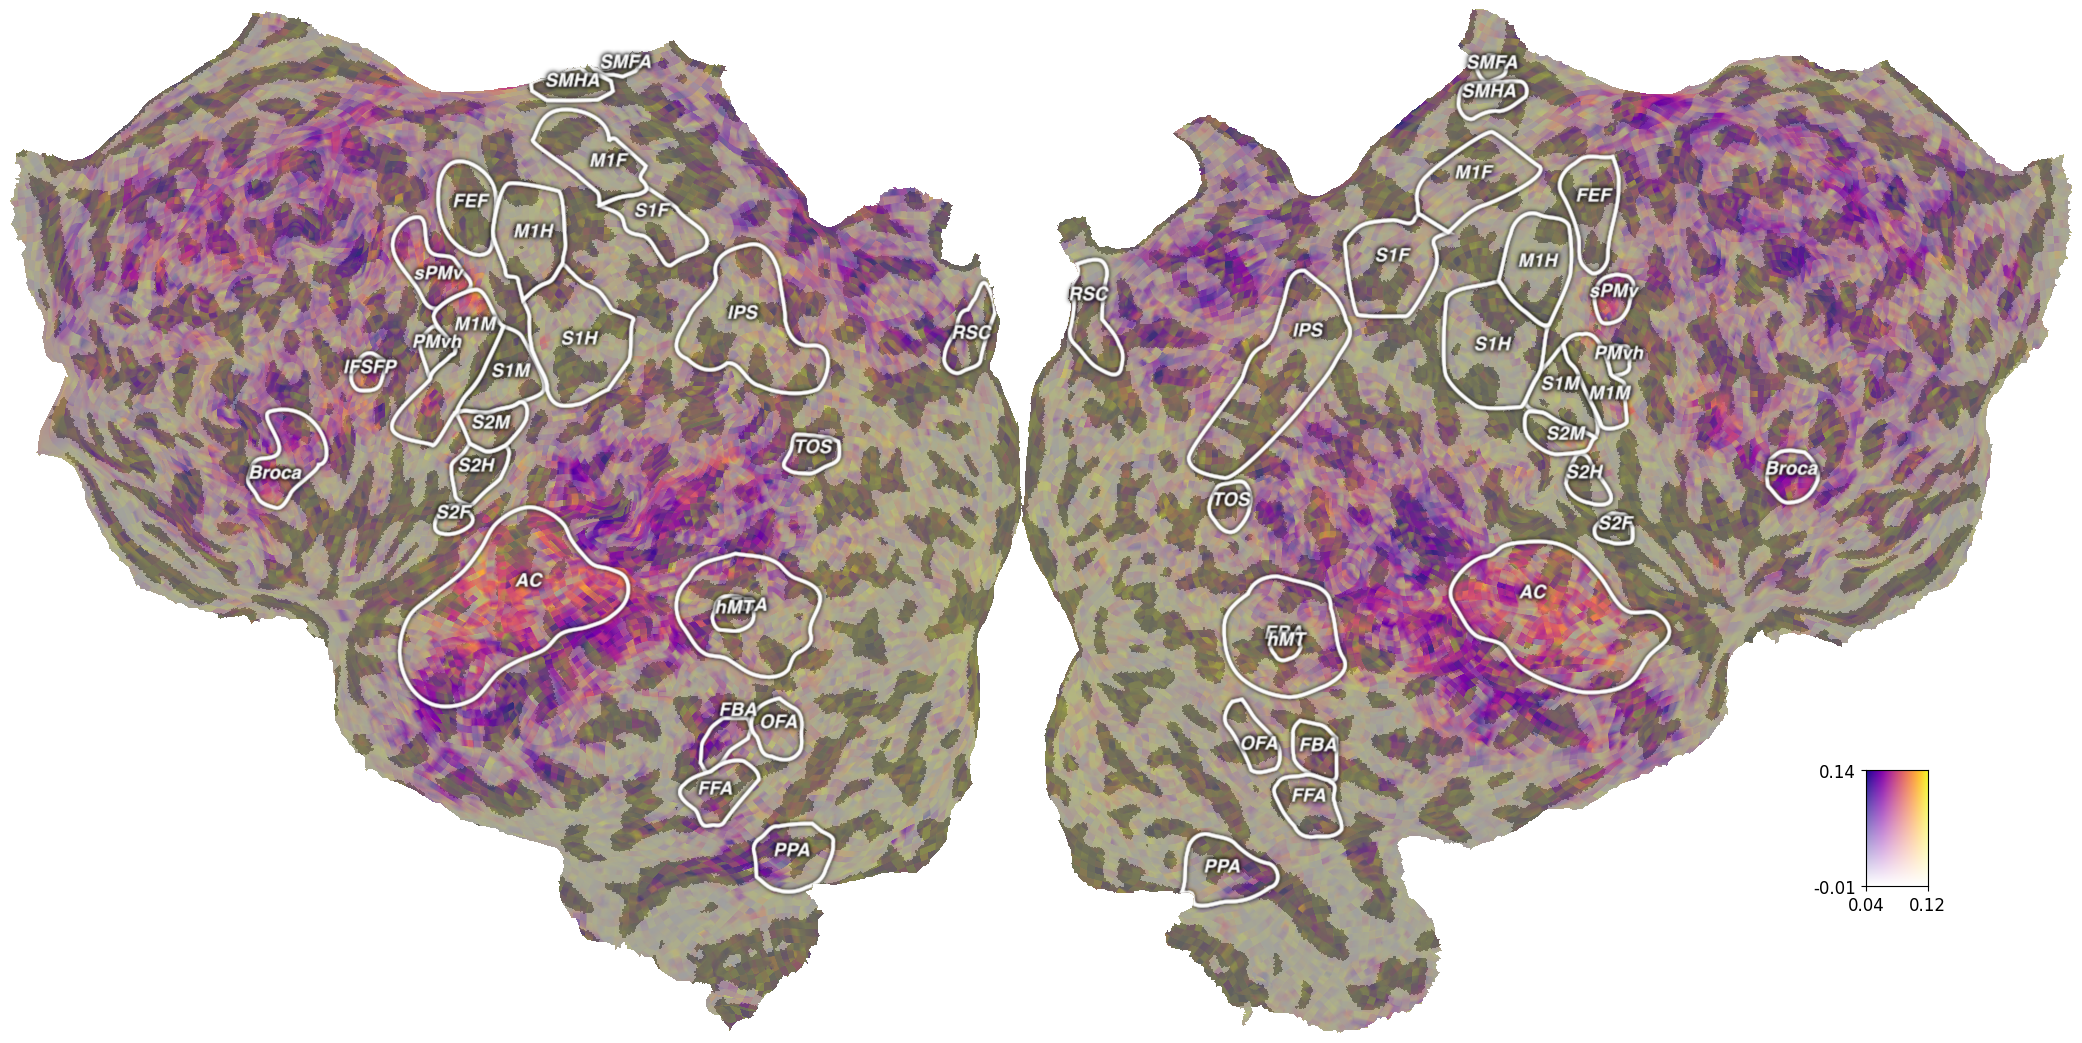

In [17]:
flatmap_kwargs = {'recache': False, 'pixelwise': True, 'sampler': 'nearest',
    'height': 1024, 'with_rois': True, #'with_labels': False, 
    'with_curvature': True, 'curvature_threshold': True, 'linewidth': 4,
    'nanmean': True}

# get weighted average of frequency bins by coherence - find the center of mass of the coherence spectrum
vol_data = np.average(np.broadcast_to(freqs[:, None], coherence_uppeohr_denoise.shape), weights= np.clip(coherence_upper_denoise,1e-10,1), axis=0)

vol2d = cortex.Volume2D(vol_data, coherence_upper_denoise.mean(0), subject, xfmname=xfm, cmap='plasma_alpha', vmin=0.04, vmax=0.12)

colorbar_location = (0.90, -0.05, 0.03, 0.5)
cortex.quickshow(vol2d, colorbar_location = colorbar_location, **flatmap_kwargs);

#### 5) Plot dim 1 = center of mass frequency weighted by PSD; dim 2 = repeatability

In [8]:
vol_data_psd = np.average(np.broadcast_to(freqs[:, None], Pxx.shape), weights=Pxx, axis=0) # center of mass PSD
repeatability = np.average(np.clip(coherence_upper_denoise,1e-10,1), weights=Pxx, axis=0) # coherence weighted by PSD
vol2d = cortex.Volume2D(vol_data_psd, repeatability, subject, xfmname=xfm, cmap='plasma_alpha',vmin= 0.05, vmax = 0.10)
colorbar_location = (0.90, -0.05, 0.03, 0.35)
cortex.quickshow(vol2d, colorbar_location = colorbar_location, **flatmap_kwargs);
plt.savefig("psd_language_brainmap.pdf", format='pdf', bbox_inches='tight')

NameError: name 'coherence_upper_denoise' is not defined

## Significance testing for coherence

#### Phase randomization test

In [114]:
# phase randomize the signals -- phase randomization doesn't work, need block randomization
from scipy.fft import fft, ifft
fft_response_trials = fft(response_trials, axis=1)

In [116]:
from concurrent.futures import ThreadPoolExecutor

def phase_randomize(fft_data):
    amplitude = np.abs(fft_data)
    rand_phase = np.random.uniform(0, 2 * np.pi, fft_data.shape)
    fft_phase_rand = amplitude * np.exp(1j * rand_phase)
    return np.real(np.fft.ifft(fft_phase_rand, axis=1))

def bootstrap_iteration(subset_voxs, fs, nfft, i):
    fft_phase_rand = phase_randomize(subset_voxs)
    freqs, spower, npower, jnpower, coherence_upper_rand, coherence_lower_rand = compute_coherence_spectrum(
        fft_phase_rand, fs=fs, nfft=nfft
    )
    ub_coherence_rand = np.mean(coherence_upper_rand, axis=1)  
    lb_coherence_rand = np.mean(coherence_lower_rand, axis=1)  

    # Print progress every 100 iterations
    if i % 100 == 0:
        print(f"  Bootstrap iteration {i} completed.")

    return (ub_coherence_rand + lb_coherence_rand) / 2

# Initialize 
n_bootstrap = 1000
fs = 0.5  # Sampling rate
nfft = 64  # FFT size

keys = roi_voxs.keys()
coherence_rand_sample = {key: np.zeros((n_bootstrap, len(freqs))) for key in keys}
coherence_p = {key: np.zeros(len(freqs)) for key in keys}

print("Starting ROI processing...")

for roi in roi_voxs:
    print(f"Processing ROI: {roi}")

    subset_voxs = fft_response_trials[:, :, roi_voxs[roi]] 

    # Parallelize bootstrapping using ThreadPoolExecutor
    with ThreadPoolExecutor() as executor:
        futures = [
            executor.submit(bootstrap_iteration, subset_voxs, fs, nfft, i)
            for i in range(n_bootstrap)
        ]

        coherence_rand_sample[roi] = np.array([future.result() for future in futures])

    print(f"Bootstrapping completed for ROI: {roi}")

    # Compute p-values for each frequency
    print(f"Computing p-values for ROI: {roi}")
    mean_coherence_denoise = np.mean(coherence_upper_denoise[:, roi_voxs[roi]], axis=1)
    for freq_idx in range(len(freqs)):
        count = np.sum(coherence_rand_sample[roi][:, freq_idx] >= mean_coherence_denoise[freq_idx])
        coherence_p[roi][freq_idx] = count / n_bootstrap

    print(f"P-value computation completed for ROI: {roi}")

print("All ROIs processed successfully!")



Starting ROI processing...
Processing ROI: AC
noise (2410, 2124)
noise (2410, 2124)
noise (2410, 2124)
noise (2410, 2124)
noise (2410, 2124)
noise (2410, 2124)
noise (2410, 2124)
noise (2410, 2124)
noise (2410, 2124)
noise (2410, 2124)
noise (2410, 2124)
noise (2410, 2124)
noise (2410, 2124)
noise (2410, 2124)
  Bootstrap iteration 0 completed.
noise (2410, 2124)
noise (2410, 2124)
noise (2410, 2124)
noise (2410, 2124)
noise (2410, 2124)
noise (2410, 2124)
noise (2410, 2124)
noise (2410, 2124)
noise (2410, 2124)
noise (2410, 2124)
noise (2410, 2124)
noise (2410, 2124)
noise (2410, 2124)
noise (2410, 2124)
noise (2410, 2124)noise (2410, 2124)

noise (2410, 2124)
noise (2410, 2124)noise (2410, 2124)

noise (2410, 2124)
noise (2410, 2124)
noise (2410, 2124)
noise (2410, 2124)
noise (2410, 2124)
noise (2410, 2124)
noise (2410, 2124)
noise (2410, 2124)
noise (2410, 2124)
noise (2410, 2124)
noise (2410, 2124)
noise (2410, 2124)
noise (2410, 2124)
noise (2410, 2124)
noise (2410, 2124)
noise (

#### Randomly sample entire runs

In [19]:
nloops = 10 
ndraws = 10
runs = list(range(response_trials.shape[0]))

sim_data = response_trials[draws,:,:]

for i in range(nloops):
    draws = np.random.choice(runs, size=ndraws, replace=True)
    sim_data = response_trials[draws,:,:]
    freqs,_,_,_,sim_coh_ub, sim_coh_lb = compute_coherence_spectrum(sim_data, fs=0.5, nfft=64)

In [22]:
draws

array([3, 4, 8, 4, 2, 7, 0, 3, 1, 8, 7, 4, 8, 5, 2, 5, 0, 7, 0, 6, 8, 1,
       8, 1, 9, 4, 0, 9, 0, 8, 2, 9, 7, 5, 3, 6, 6, 4, 2, 2, 6, 8, 8, 1,
       3, 0, 0, 5, 4, 1, 8, 9, 2, 3, 4, 5, 2, 1, 9, 0, 4, 5, 9, 9, 8, 4,
       0, 2, 2, 3, 5, 8, 2, 8, 9, 8, 2, 5, 3, 0, 0, 2, 4, 8, 9, 4, 8, 9,
       3, 4, 6, 8, 3, 6, 6, 3, 1, 6, 0, 5])

In [23]:
print(sim_data[0,:,0])
print(response_trials[3,:,0])

[ 7.36002375e-02  1.04206651e+00 -5.15304537e-02 -1.00503056e+00
  2.31927990e+00 -6.20337928e-01 -3.00820449e-01 -2.16223011e+00
  1.45356657e+00 -8.97583211e-01 -2.78546165e-01 -1.15729970e+00
 -1.21638002e-01 -1.69231755e-01 -7.42816505e-02  6.60046314e-01
 -9.09219195e-01  7.18863408e-01 -9.34762621e-01 -2.98706617e-01
  5.47938716e-01  2.72098293e-01  7.49870812e-01  1.35181289e+00
  1.92750813e-01  3.27222329e-01 -2.82598981e+00 -3.82795524e-01
 -4.20356670e-01  4.42740347e-01 -7.29163153e-01 -5.50779509e-01
  4.18011047e-01  9.30672239e-02 -7.79310054e-01 -1.02101673e+00
  1.11440545e-01 -5.86899294e-02  9.23555901e-01  1.46133753e-01
  1.17963846e+00  2.37699434e-02  2.87689167e-01 -1.94935228e-01
  3.12029908e-01  2.61573710e+00  8.23740798e-02 -9.26647994e-01
 -2.68946123e-02 -1.11447161e+00 -2.52014240e-01 -2.17596390e-01
 -1.14187567e+00  7.53741203e-02  1.70347670e+00  1.35386477e+00
 -2.35722908e-01 -1.37658278e-01  7.34770333e-01  1.36202378e+00
  1.87859624e+00  3.21288